# Dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import lightning as L
from torchvision.models import vit_b_16, vit_b_32 # pretrained model
import torchmetrics
import cv2
import optuna
import optuna.visualization as ov
import albumentations as A
import yaml
import joblib

c:\Users\NIels\anaconda3\envs\deep_learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\NIels\anaconda3\envs\deep_learning\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Modify the Python Path in Notebook

In [ ]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../src")))

In [ ]:
import datasets as btd
from transforms import CropImgTransform
from utils import show_image_grid
from config import TEST_DATA_PATH, TRAIN_DATA_PATH
from augmentations import augment_data, show_augmentations

# Setup data

In [ ]:
# Define the transformation for the images
transform = transforms.Compose([
	transforms.Grayscale(num_output_channels=3),   # convert to 3 channels
	transforms.Resize((224, 224)),                 # resize to 224x224
	transforms.ToTensor(),
])

# Load your datasets with the defined transformations
train_dataset = btd.BrainTumorDataset(TRAIN_DATA_PATH, transform=transform)
test_dataset = btd.BrainTumorDataset(TEST_DATA_PATH, transform=transform)

val_size = len(test_dataset) // 2
test_size = len(test_dataset) - val_size
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataset), len(test_dataset), len(val_dataset)

(5893, 656, 655)

## Inspection of the data distribution

In [3]:
# histogram of the classes in each dataset
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]
val_labels = [label for _, label in val_dataset]

train_hist = np.histogram(train_labels, bins=4)
test_hist = np.histogram(test_labels, bins=4)
val_hist = np.histogram(val_labels, bins=4)

train_hist, test_hist, val_hist

((array([1502, 1339, 1595, 1457], dtype=int64),
  array([0.  , 0.75, 1.5 , 2.25, 3.  ])),
 (array([154, 157, 195, 150], dtype=int64),
  array([0.  , 0.75, 1.5 , 2.25, 3.  ])),
 (array([146, 149, 210, 150], dtype=int64),
  array([0.  , 0.75, 1.5 , 2.25, 3.  ])))

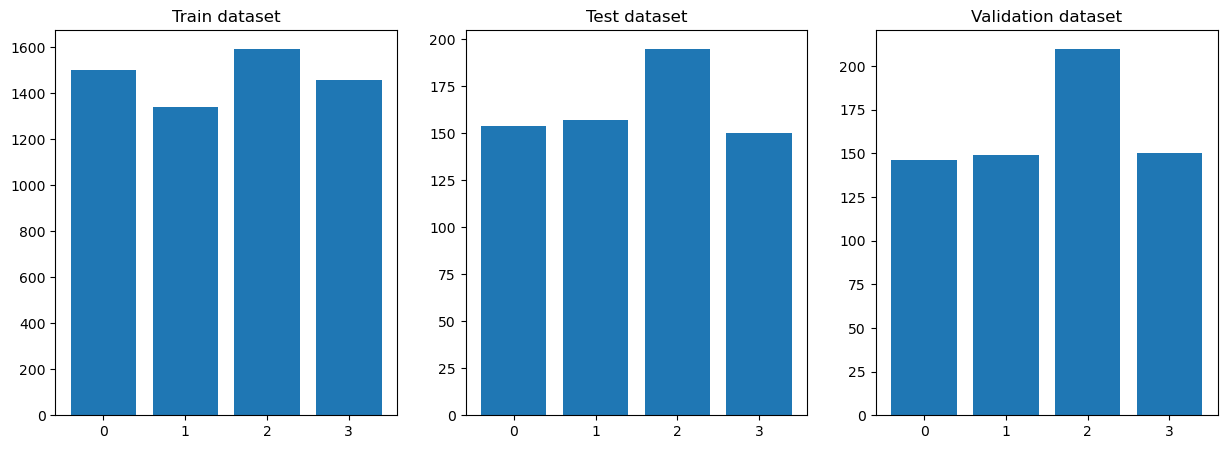

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].bar(range(4), train_hist[0])
ax[0].set_title('Train dataset')
ax[1].bar(range(4), test_hist[0])
ax[1].set_title('Test dataset')
ax[2].bar(range(4), val_hist[0])
ax[2].set_title('Validation dataset')
plt.show()


# Data Augmentation

| **Augmentation**               | **Why Use It?**                                                                                           |
|---------------------------------|----------------------------------------------------------------------------------------------------------|
| **Rotate**                     | Simulates orientation differences.                                                                       |
| **Horizontal**				 | Increases diversity while retaining symmetry.                                                           |
| **Random Crop**                | Focuses on smaller regions of interest.                                                                 |
| **Elastic Transform**          | Introduces non-rigid variations.                                                                        |
| **Brightness/Contrast Adjustment** | Mimics scanner variability.                                                                             |
| **CLAHE**                      | Enhances local contrast, highlighting subtle features.                                                  |
| **Gaussian Noise**             | Simulates noisy scans.                                                                                  |
| **Compression**                | Mimics lossy storage artifacts.                                                                         |
| **Coarse Dropout**             | Simulates signal loss or occluded areas.                                                                |


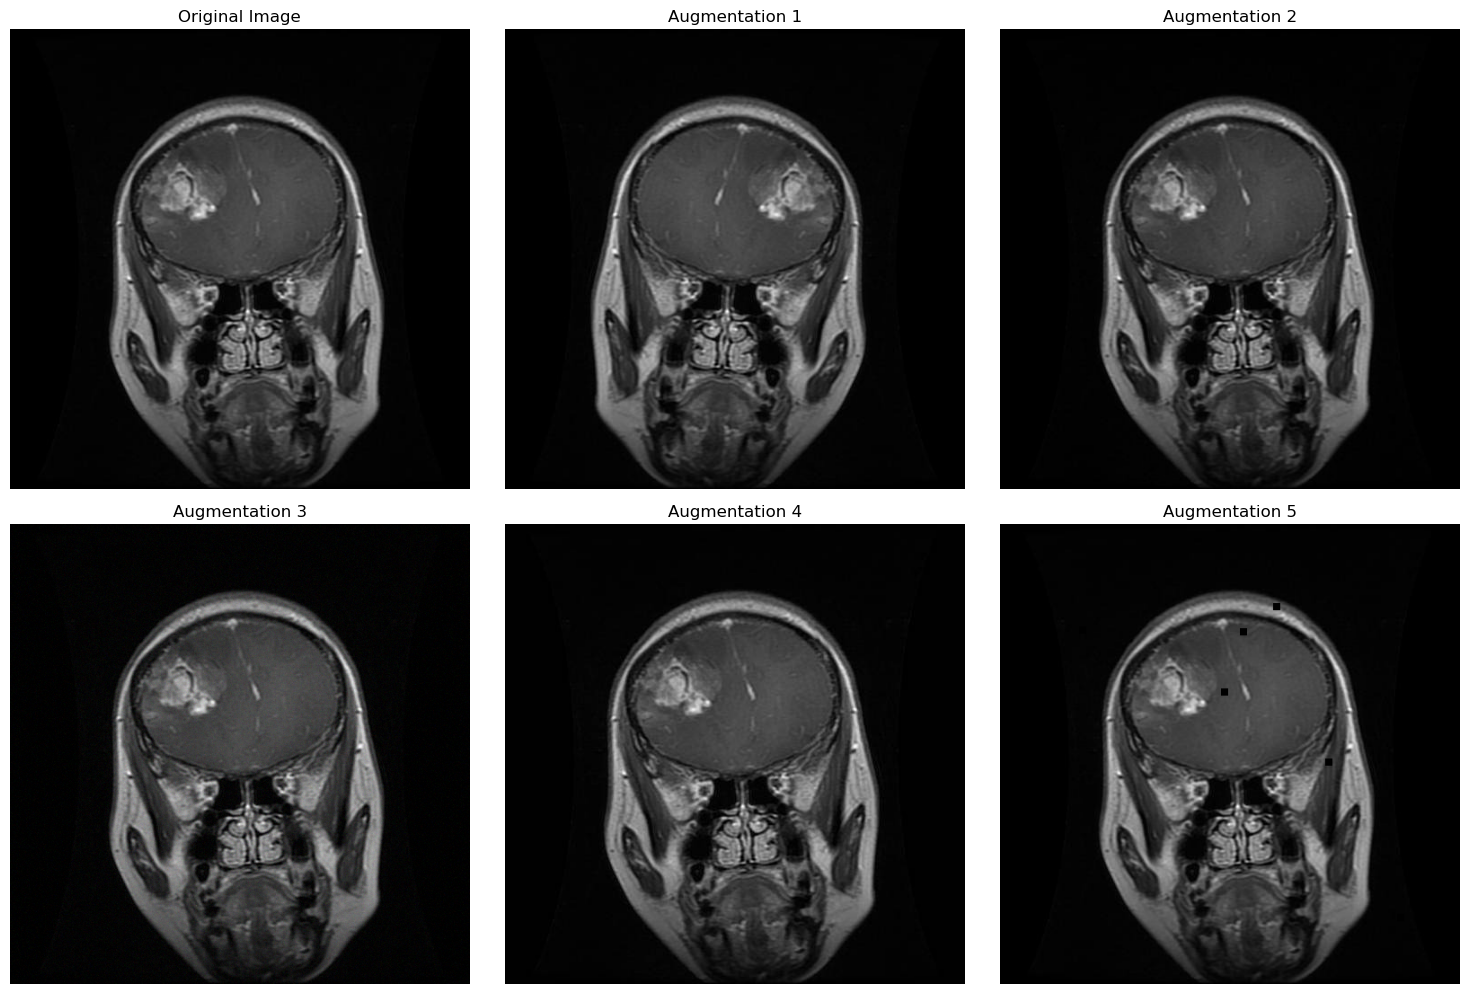

In [ ]:
augmentations = A.Compose([
    # Geometric transformations
    A.HorizontalFlip(p=0.5),  # Random horizontal flip

	# intensity and contrast transformations
    A.RandomGamma(p=.5),  # Random gamma adjustment for exposure variance

	# Noise and artifacts
    A.GaussNoise(p=.5),  # Simulates random noise in the image from the scanning process
    A.ImageCompression(quality_range=(60, 95), p=0.5),  # Simulates image compression artifacts
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.5),  # Simulates missing parts of the image
])

train_dataset = btd.BrainTumorDataset(TRAIN_DATA_PATH)
show_augmentations(train_dataset[0][0], augmentations)

In [ ]:
augment_data(augmentations=augmentations,
                 file_path=TRAIN_DATA_PATH,
                 num_augmentations=2,
                 overwrite=True)

# Setup classifier

In [ ]:
# Define the PyTorch Lightning Module
class BrainTumorClassifier(L.LightningModule):
	def __init__(self, 
			  learning_rate=1e-3, 
			  patch_size=16,
			  batch_size=32,
			  pretrained_weights = "IMAGENET1K_V1"):
		super().__init__()
		# Initialize the model with the pre-trained ViT
		if patch_size == 16:
			self.model = vit_b_16(weights=pretrained_weights)
		elif patch_size == 32:
			self.model = vit_b_32(weights=pretrained_weights)

		self.model.heads = torch.nn.Linear(self.model.hidden_dim, 4)  # Modify for 4 classes

		# Define loss function and learning rate
		self.criterion = torch.nn.CrossEntropyLoss()
		self.learning_rate = learning_rate

		# Initialize accuracy metric for logging
		self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)
		self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)

		self.attention_maps = {}  # To store attention maps

	def forward(self, x):
		return self.model(x)

	def training_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
		self.train_accuracy(outputs, labels)
		self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True)

		return loss
	
	def validation_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('val_loss', loss, on_epoch=True, prog_bar=True)
		self.val_accuracy(outputs, labels)
		self.log('val_acc', self.val_accuracy, on_epoch=True, prog_bar=True)

		return loss

	def test_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('test_loss', loss, on_epoch=True, prog_bar=True)
		self.val_accuracy(outputs, labels)
		self.log('test_acc', self.val_accuracy, on_epoch=True, prog_bar=True)

		self.log_attention_maps(inputs, labels, outputs, batch_idx)  # Save attention maps

		return loss
	
	def configure_optimizers(self):
		return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
	
	def register_attention_hooks(self):
		"""Register hooks to capture attention maps."""
		self.attention_maps.clear()  # Reset attention maps

		def hook_fn(module, input, output, module_name):
			module_name = module_name.split(".")[2]  # Get the layer name
			self.attention_maps[module_name] = output[1]  # Save attention map

		# Register hooks on all MultiheadAttention layers
		for i, module in self.model.named_modules():
			if isinstance(module, torch.nn.MultiheadAttention):
				module.register_forward_hook(lambda module, input, output, module_name=i: hook_fn(module, input, output, module_name))
	
	def on_test_start(self):
		# Register the hook to each multi-head attention layer before testing
		self.register_attention_hooks()

	def log_attention_maps(self, inputs, labels, output, batch_idx):
			"""Log attention maps overlaid on the original image using Lightning's logger."""
			predicted_labels = [btd.BrainTumorDataset().idx_to_class[lbl.item()] for lbl in torch.argmax(output, dim=1)]
			batch_size = inputs.size(0)
			for i in range(batch_size):
				rollout_attention_map = torch.eye(self.attention_maps['encoder_layer_1'].size(-1))
				for _, attention in self.attention_maps.items():
					# Get the attention map for the first image in the batch
					attention_map = attention[i]  # Shape: [num_tokens, embedding_size]

					attention_map = attention_map + torch.eye(attention_map.size(-1))  # Add identity matrix
					attention_map /= attention_map.sum(dim=-1, keepdim=True)  # Normalize attention map

					rollout_attention_map = torch.matmul(rollout_attention_map, attention_map)

				num_patches_side = int((attention_map.size(0) - 1) ** 0.5)
				class_token_embedding = rollout_attention_map[0, 1:] # Shape: (embedding_size)
				attention_map = 1 - class_token_embedding.view(num_patches_side, num_patches_side, -1).clone()
				attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

				average_attention_map = attention_map.cpu().detach().numpy()
				average_attention_map = cv2.resize(average_attention_map, (inputs.size(2), inputs.size(3)))
				heatmap = cv2.applyColorMap(np.uint8(255 * average_attention_map), cv2.COLORMAP_JET)

				# Overlay the heatmap on the original image
				image = inputs[i].cpu().numpy().transpose(1, 2, 0)
				image = (image*255).astype(np.uint8)
				overlayed_image = cv2.addWeighted(image, 0.8, heatmap, 0.4, 0)

				# add class label
				label = labels[i].item()
				label = btd.BrainTumorDataset().idx_to_class[label]
				cv2.putText(overlayed_image, f"Real class: {label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
				cv2.putText(overlayed_image, f"Predicted class: {predicted_labels[i]}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

				# convert to chw
				overlayed_image = overlayed_image.transpose(2, 0, 1)

				# Create a blank image to place the original and overlayed images side by side
				combined_image = np.zeros((inputs.size(2), inputs.size(3) * 2, 3), dtype=np.uint8)

				# Place the original image on the left
				combined_image[:, :inputs.size(3), :] = image

				# Place the overlayed image on the right
				overlayed_image = overlayed_image.transpose(1, 2, 0)  # Convert back to HWC
				combined_image[:, inputs.size(3):, :] = overlayed_image

				# Convert back to CHW for logging
				combined_image = combined_image.transpose(2, 0, 1)

				# log to tensorboard
				self.logger.experiment.add_image(f'attn_map/batch_{batch_idx}/img_{i}', combined_image, self.current_epoch)

# Model training (without Optuna)

In [28]:
# Create the model instance
model = BrainTumorClassifier()

# Define callbacks
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
	monitor="val_loss",                     # Monitor validation loss
	mode = "min",                           # mode for monitored metric
	dirpath="checkpoints/",                   # Directory to save checkpoints
	filename="epoch-{epoch:02d}-val_loss-{val_loss:.2f}",  # Naming pattern
	save_top_k=-1,                          # Save all checkpoints
	every_n_epochs=1,                       # Save at every epoch
)

early_stopping_callback = L.pytorch.callbacks.EarlyStopping(
	monitor="val_loss",                     # Metric to monitor
	patience=5,                             # Stop training if no improvement for 5 epochs
	mode="min",                             # Stop when `val_loss` stops decreasing
)

logger = L.pytorch.loggers.TensorBoardLogger("logs", name="vit_pretrained")


# Define the PyTorch Lightning Trainer
trainer = L.Trainer(max_epochs=10, 
					accelerator="auto", 
					logger=logger,
					callbacks=[checkpoint_callback, early_stopping_callback])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
# Train the model
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# Training (using Optuna)
Based on [this guide](https://medium.com/swlh/optuna-hyperparameter-optimization-in-pytorch-9ab5a5a39e77)

In [ ]:
# Define the objective function for Optuna (the function to optimize)
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    patch_size = trial.suggest_categorical('patch_size', [16])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Create the model and data module with suggested hyperparameters
    model = BrainTumorClassifier(learning_rate=learning_rate,
                                 patch_size=patch_size,
                                 batch_size=batch_size)

	# Define callbacks
    checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
		monitor="val_loss",                     # Monitor validation loss
		mode = "min",                           # mode for monitored metric
		dirpath="checkpoints/",                   # Directory to save checkpoints
		filename="epoch-{epoch:02d}-val_loss-{val_loss:.2f}",  # Naming pattern
		save_top_k=-1,                          # Save all checkpoints
		every_n_epochs=1,                       # Save at every epoch
	)

    early_stopping_callback = L.pytorch.callbacks.EarlyStopping(
		monitor="val_loss",                     # Metric to monitor
		patience=5,                             # Stop training if no improvement for 5 epochs
		mode="min",                             # Stop when `val_loss` stops decreasing
	)

    logger = L.pytorch.loggers.TensorBoardLogger("logs", name="vit_pretrained")

    # Define the PyTorch Lightning Trainer
    trainer = L.Trainer(
        max_epochs=20,
        accelerator="auto",
        logger=logger,
        callbacks=[early_stopping_callback],
    )

    # Train the model
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # save the model
    trainer.save_checkpoint(f"vit_pretrained_{trial.number}.ckpt")

    # Evaluate the model
    val_loss = trainer.callback_metrics["val_loss"].item()

    # report intermediate objective value
    trial.report(val_loss, step=trainer.current_epoch)

    # Handle pruning based on the intermediate value
    if trial.should_prune():
        raise optuna.TrialPruned()

    return val_loss

In [ ]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="minimize", study_name="vit_pretrained")
study.optimize(objective, n_trials=12, show_progress_bar=True, n_jobs=3)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

In [ ]:
import joblib # Save the study
import time

now = time.strftime("%Y-%m-%d-%H-%M")
study_name = f"vit_pretrained_study_{now}.pkl"
joblib.dump(study, study_name)

# Model testing

During testing, attention maps are generated for each image.

In [38]:
# setup the paths
root = "logs"
name = "vit_pretrained/colab_run5"
version = "version_6"

path = f"{root}/{name}/{version}"
weights_path = f"{path}/vit_pretrained_6_root.ckpt"

# Load the model weights
model = BrainTumorClassifier.load_from_checkpoint(weights_path)

In [39]:
# run test
logger = L.pytorch.loggers.TensorBoardLogger(root, name=name, version=version)
trainer = L.Trainer(logger=logger, accelerator="auto")

trainer.test(model, dataloaders=test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|██████████| 21/21 [02:07<00:00,  0.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9695122241973877
        test_loss           0.08993854373693466
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.08993854373693466, 'test_acc': 0.9695122241973877}]

# Inspection of Tensorboard files

In [39]:
import json
# load loss and acc files from json
train_loss = json.load(open(f'{path}/{version}_train_loss.json', 'r'))
train_acc = json.load(open(f'{path}/{version}_train_acc.json', 'r'))
val_loss = json.load(open(f'{path}/{version}_val_loss.json', 'r'))
val_acc = json.load(open(f'{path}/{version}_val_acc.json', 'r'))

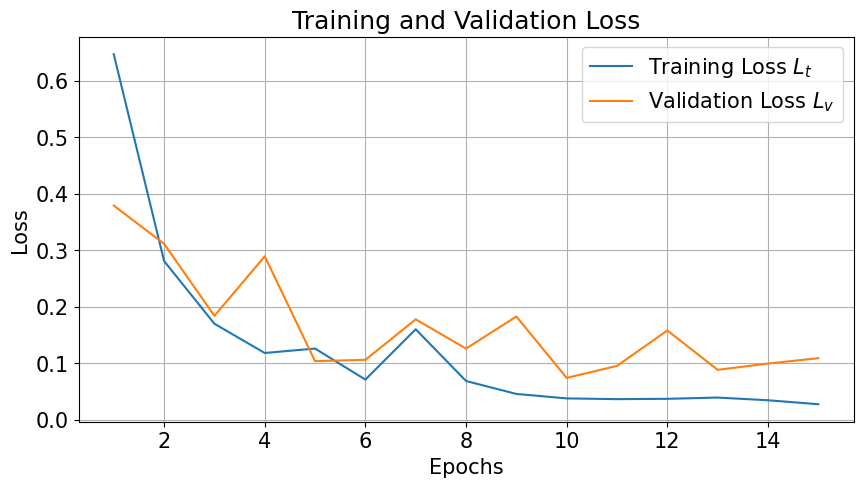

In [48]:
import matplotlib.pyplot as plt

# Extract the epoch numbers and loss values
epochs = list(range(1, len(train_loss) + 1))
train_loss_values = [loss[2] for loss in train_loss]
val_loss_values = [loss[2] for loss in val_loss]

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_values, label='Training Loss $L_t$')
plt.plot(epochs, val_loss_values, label='Validation Loss $L_v$')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.rcParams.update({'font.size': 15})
plt.show()

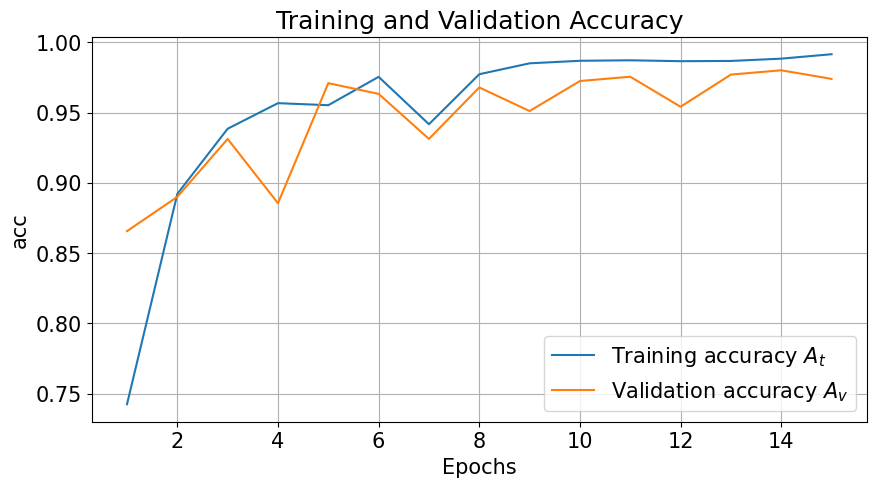

In [49]:
# Extract the epoch numbers and loss values
epochs = list(range(1, len(train_acc) + 1))
train_acc_values = [acc[2] for acc in train_acc]
val_acc_values = [acc[2] for acc in val_acc]

# Plot the training and validation acc
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_values, label='Training accuracy $A_t$')
plt.plot(epochs, val_acc_values, label='Validation accuracy $A_v$')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.rcParams.update({'font.size': 15})
plt.show()

# Inspection of Optuna results

In [ ]:
# to load it:
# https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html
study = joblib.load("logs/vit_pretrained/colab_run5/vit_pretrained_study_2024-12-05-14-55.pkl")
print(study.best_trial.params)

{'learning_rate': 0.00016501192788890502, 'patch_size': 16, 'batch_size': 128}


In [11]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_learning_rate,params_patch_size,state
0,0,0.157173,2024-12-05 06:55:49.032475,2024-12-05 09:37:03.126183,0 days 02:41:14.093708,128,0.000322,16,COMPLETE
1,1,0.198278,2024-12-05 06:55:49.034102,2024-12-05 08:49:32.192154,0 days 01:53:43.158052,128,0.000428,16,COMPLETE
2,2,0.254228,2024-12-05 06:55:49.037257,2024-12-05 08:50:15.519120,0 days 01:54:26.481863,32,0.000580,16,COMPLETE
3,3,0.148939,2024-12-05 08:49:32.199556,2024-12-05 10:43:00.999844,0 days 01:53:28.800288,64,0.000277,16,COMPLETE
4,4,0.138225,2024-12-05 08:50:15.526563,2024-12-05 10:44:14.676744,0 days 01:53:59.150181,64,0.000305,16,COMPLETE
5,5,0.152461,2024-12-05 09:37:03.134107,2024-12-05 12:17:59.726110,0 days 02:40:56.592003,128,0.000244,16,COMPLETE
6,6,0.108762,2024-12-05 10:43:01.007439,2024-12-05 12:08:05.890919,0 days 01:25:04.883480,128,0.000165,16,COMPLETE
7,7,0.179275,2024-12-05 10:44:14.682528,2024-12-05 12:38:07.396795,0 days 01:53:52.714267,32,0.000674,16,PRUNED
8,8,0.309945,2024-12-05 12:08:05.897813,2024-12-05 13:33:48.374986,0 days 01:25:42.477173,32,0.000317,16,PRUNED
9,9,0.182242,2024-12-05 12:17:59.731745,2024-12-05 14:45:20.183836,0 days 02:27:20.452091,64,0.000909,16,PRUNED


In [ ]:
ov.plot_optimization_history(study)

In [ ]:
fig = ov.plot_parallel_coordinate(study, params=["learning_rate", "batch_size"])
# increase font size
fig.update_layout(font=dict(size=17))
fig.show()

In [ ]:
# parameter importances
ov.plot_param_importances(study)

In [62]:
# contour plot
ov.plot_contour(study, params=["learning_rate", "batch_size"])

# LIME

In [ ]:
from lime import lime_image

In [ ]:
# Create the model instance
weights_path = f"{path}/vit_pretrained_6_root.ckpt"
model = BrainTumorClassifier()
model = BrainTumorClassifier.load_from_checkpoint(weights_path, map_location=model.device)

In [ ]:
explainer = lime_image.LimeImageExplainer(verbose=True, random_state= 1, kernel_width=0.5)

image = test_dataset[68]

In [ ]:
image = image[0]

In [ ]:
image_np = image.permute(1, 2, 0).cpu().numpy()  # [3, 224, 224] -> [224, 224, 3]

# Ensure the data type is float32
image_np = image_np.astype(np.float32)

In [ ]:
def predict_func(inputs):
    """
    Predict function compatible with LIME for batch predictions.

    Args:
        inputs: NumPy array of shape (batch_size, height, width, channels)

    Returns:
        NumPy array of probabilities of shape (batch_size, num_classes)
    """
    # Convert NumPy array to PyTorch tensor and reshape to [batch_size, channels, height, width]
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32).permute(0, 3, 1, 2)
    
    # Move tensor to the same device as the model
    inputs_tensor = inputs_tensor.to(model.device)
    
    with torch.no_grad():
        # Forward pass for predictions
        outputs = model(inputs_tensor)  # Shape: [batch_size, num_classes]

        # Apply softmax to get probabilities
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()  # Convert to NumPy
    
    return probabilities


In [ ]:
from skimage.segmentation import slic
explanation = explainer.explain_instance(image_np, predict_func, top_labels=1, num_samples=100, segmentation_fn = lambda image:slic(image, n_segments = 60, compactness = 5))

### Comments 
Model is very sure of the prediction, however intercept is very high, which will in turn make the weights of the local model very small thus making it harder to distinguish between superpixel importace. 

This can be fixed by playing around with the kernel width. 


In [ ]:
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic
import matplotlib.pyplot as plt


# Get the explanation for the top label
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],  # Label to explain
    positive_only=True,               # Show only positive contributions
    num_features=1,                   # Number of superpixels to highlight
    hide_rest=False                   # Show the rest of the image
)


# Create the overlay with boundaries on the original image
overlay_image = mark_boundaries(temp, mask)

# Plot the overlay on top of the original image
plt.figure(figsize=(6, 6))
plt.imshow(overlay_image)
plt.axis("off")
plt.title("Explanations Overlayed on Original Image")
plt.show()


### LIME to explain image classification 

The task of this notebook is to explain the black-box vision-transformer prediction for classification of brain cancer. 


### Lime (Local Interpretable Model-agnostic Explanations)
Lime can be used to explain any black-box model. In short it works by permuting a single input feature (the feature which you want to explain) and then training a regression model on the permuted features and the black-box predictions. 


When we apply lime to explain image classification we first use image segmentation, in our case superpixels. Each of these superpixels are treated as a meaningful explanation of the data. 

Then lime crates permuted images by turning super pixels on and off. 

Then lime performs black-box predictions based on these permuted images. These predictions then gives insight in how each superpixel effect the output. 

Finally lime fits a regression model which model the relationship between superpixel and output. This gives us an indication of super pixel importance. 

### References 

https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image

https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html